# Pronóstico adaptativo

## Descripción del problema real

Los pronósticos de los precios de la electricidad en mercados liberalizados son un insumo fundamental para la toma de decisiones dentro de las organizaciones. Fundamentalmente, los pronosticos de corto plazo son utilizados en decisiones de carácter operativo. En el caso abordado, es necesario contar con los pronósticos para definir la politica de operación de una empresa del sector eléctrico.

## Descripción del problema en términos de los datos

La carpeta `datos/precios/` contiene los precios historicos horarios de la electricidad en la Bolsa de Energía del mercado eléctrico colombiano, publicados por el operador del mercado. Se desean obtener pronósticos para el precio promedio diario para los próximos siete (7) días a la fecha actual.

## Aproximaciones posibles

En este caso, se desea evaluar la capacidad de pronóstico de un ADALINE con aprendizaje en línea.

## Requerimientos

Usted debe:

* Procesar los datos históricos para conformar el conjunto de datos. Los archivos de Excel no pueden ser modificados y actualizados directamente por el operador del sistema. Su código debe leer los archivos y crear la serie de precios promedio diarios de la electricidad.


* Determinar si el modelo debe pronosticar los precios promedios sin ninguna transformación, o si la inclusión de una transformación (logaritmo natural, raíz cúbica, raíz cuadrada, etc) resulta en un incremento de la precisión del pronóstico.


* Generar el pronóstico para los precios de los próximos siete días.


* Preparar el código para que el modelo sea entrenado usando el gradiente y el momentum.


* Determinar cuál es el número óptimo de retardos (observaciones) que el modelo debe considerar hacia atrás para producir el pronóstico.


* Determinar los valores óptimos de la tasa de aprendizaje y el momentum.


# Primero se hace la lectura de los datos

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import math
tf.enable_eager_execution()


años = range(1995,2016,1)
Datos = []
for i in años:
    archivo_excel = pd.read_excel('./datos/precios/Precio_Bolsa_Nacional_($kwh)_'+str(i)+'.xlsx')
    for r in range(3,archivo_excel[archivo_excel.columns[0]].size):
        suma = 0
        for j in range(1,25):
            if(not(math.isnan(archivo_excel[archivo_excel.columns[j]][r]))):
                suma = suma + archivo_excel[archivo_excel.columns[j]][r]             
       
        try:
            Datos.append([archivo_excel[archivo_excel.columns[0]][r].strftime("%Y-%m-%d"),suma/24])
        except:
            Datos.append([archivo_excel[archivo_excel.columns[0]][r],suma/24])
            
        
for i in [2016, 2017, 2018]:
    archivo_excel = pd.read_excel('./datos/precios/Precio_Bolsa_Nacional_($kwh)_'+str(i)+'.xls')
    for r in range(3,archivo_excel[archivo_excel.columns[0]].size):
        suma = 0
        for j in range(1,25):
            if(not(math.isnan(archivo_excel[archivo_excel.columns[j]][r]))):
                suma = suma + archivo_excel[archivo_excel.columns[j]][r]   
        try:
            Datos.append([archivo_excel[archivo_excel.columns[0]][r].strftime("%Y-%m-%d"),suma/24])
        except:
            Datos.append([archivo_excel[archivo_excel.columns[0]][r],suma/24])
        
#Se cargan los datos del IPC
excel_ipc = pd.read_excel('./datos/precios/1.2.5.IPC_Serie_variaciones.xlsx')
ipc_mes = []
for i in range (12, 308):
    ipc_mes.append([excel_ipc[excel_ipc.columns[0]][i],excel_ipc[excel_ipc.columns[1]][i]])

mes = ["07","08","09","10","11","12"]
cmes = 0
ipcdato=0
ipc_mes.reverse()
DXIPC = []
for idato in range(0,len(Datos)):
    dato = Datos.pop(0)
    if(not((str("1995-"+mes[cmes]) in dato[0]))):
        ipcdato = ipcdato + 1
        cmes = cmes + 1
        if(cmes == 6):
            break
    
    DXIPC.append((float(dato[1])*float(ipc_mes[ipcdato][1]/100)))            
            
años = range(1996,2019,1)
caño = 0
cmes2 = 0
mes2 = ["01","02","03","04","05","06","07","08","09","10","11","12"]
for dato in Datos:
    if(not((str(años[caño])+"-"+mes2[cmes2]) in dato[0])):
        ipcdato = ipcdato + 1
        cmes2 = cmes2 + 1
        if(cmes2 == 12):
            cmes2 = 0
            caño = caño +1
    DXIPC.append((float(dato[1])*float(ipc_mes[ipcdato][1]/100)))      
                


C:\Users\HP\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\HP\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\HP\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\HP\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1)

# Modelo en TensorFlow

In [5]:
class Model(object):
    def __init__(self, L):
        self.w = tf.Variable([0.0] * (L+1))

    def __call__(self, x):
        x = tf.constant(np.array([1.0] + x, dtype=np.float32))
        y_pred = tf.reduce_sum(tf.multiply(self.w, x))
        return y_pred

    def fit(self, mu, x, y_desired):
        y_pred = self(x)
        e = y_desired - y_pred
        x = tf.constant(np.array([1.0] + x, dtype=np.float32))
        self.w.assign_add(tf.scalar_mul(2 * mu * e, x))

# Se definen las transformaciones a los datos

In [3]:
l = len(DXIPC)
maxd = max(DXIPC)
mind = min(DXIPC)
rmm = maxd-mind
#Normalización
nxipc = []
#Cuadraro
c2ipc = []
#Raíz
r2ipc = []
#Logaritmo
lnipc = []
for i in range(l):
    nxipc.append((maxd - DXIPC[i])/rmm)
    c2ipc.append(DXIPC[i]**2)
    r2ipc.append(math.sqrt(DXIPC[i]))
    lnipc.append(math.log(DXIPC[i]))


datasets = [nxipc,c2ipc,r2ipc,lnipc]
def denormalize(x):
    return ((-rmm*x)/maxd)

# Se eligen la tasa de aprendizaje, rezagos y transformación

In [6]:
minperr = [0,0,float('inf'),-1]
for D in [0,2,3]:
    for L in range(7,15):
        deseados = datasets[D][:len(datasets[D])-L]
        y_pred = np.empty(len(deseados))
        y_pred[:] = np.nan
        
        for mu in np.arange(0.01, 0.1, 0.01):
            model = Model(L)
            errorst = 0
            
            for t in range(L, len(deseados)):
                x = deseados[t-L:t]
                mx = model(x)
                if(D==0):
                    errorst = errorst + ((denormalize(-rmm*deseados[t])-denormalize(mx))**2)
                elif(D==1):
                    p1= math.sqrt(deseados[t])
                    p2= math.sqrt(abs(mx))
                    errorst = errorst + ((p1-p2)**2)
                elif(D==2):
                    errorst = errorst + (((deseados[t]**2)-(mx**2))**2)
                elif(D==3):
                    try:
                        errorst = errorst + ((math.exp(deseados[t])-math.exp(mx))**2)
                    except:
                        errorst = errorst
                        
                model.fit(mu=mu, x=x, y_desired=deseados[t])
            promact = [L,mu,errorst/l,D]
            
            if(promact[2]<minperr[2]):
                minperr=promact
             
        
            
    
print(minperr)
k = 0

[14, 0.01, <tf.Tensor: id=13318967, shape=(), dtype=float32, numpy=2601888.8>, 0]


# Se entrena el mejor modelo

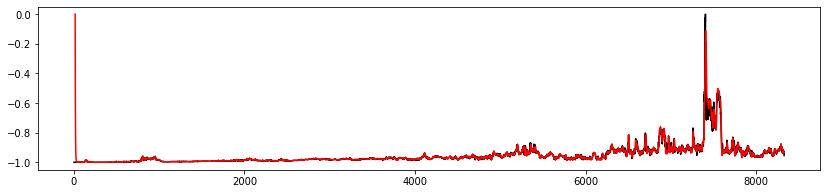

In [9]:

deseados = datasets[minperr[3]][:len(datasets[minperr[3]])-minperr[0]]
y_pred = np.empty(len(deseados))
y_pred[:] = np.nan

desden = []
model = Model(minperr[0])
for i in deseados:
    desden.append(denormalize(i))

for t in range(minperr[0], len(deseados)):
    x = deseados[t-L:t]
    mx = model(x)
    y_pred[t] = denormalize(mx)
    model.fit(minperr[1], x=x, y_desired=deseados[t])
            

plt.figure(figsize=(14,3))
plt.plot(desden, color='black');
plt.plot(y_pred, color = 'red');

test = datasets[minperr[3]][len(datasets[minperr[3]])-3*minperr[0]:]
for u in range(minperr[0], len(test)):
    k = k+1
    x = test[u-minperr[0]:u]
    mx = model(x)
    

# Se predice con el modelo previamente entrenado

In [8]:
prediccion = datasets[minperr[3]][len(datasets[minperr[3]])-14:]


for e in range(7):
    x = prediccion[e:]
    mx = model(x)
    prediccion.append(mx)
    print("Predicción> ",mx)

Predicción>  tf.Tensor(0.95187557, shape=(), dtype=float32)
Predicción>  tf.Tensor(0.9515618, shape=(), dtype=float32)
Predicción>  tf.Tensor(0.9525547, shape=(), dtype=float32)
Predicción>  tf.Tensor(0.95412207, shape=(), dtype=float32)
Predicción>  tf.Tensor(0.9556645, shape=(), dtype=float32)
Predicción>  tf.Tensor(0.9568597, shape=(), dtype=float32)
Predicción>  tf.Tensor(0.95786214, shape=(), dtype=float32)
